In [1]:
# ignorer dette
%load_ext autoreload
%autoreload 2

Her laster vi inn alt vi trenger. Det vil si alt av funksjoner, samt selve KI-modellen og de forhåndslagde embeddingsene for paragrafene.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from src.embedding_model import embed

Her definerer vi referanseteksten, og kalkulerer embeddingen til den den.

In [3]:
inn_text = "Innovasjon i offentlig sektor kan være en ny eller vesentlig endret tjeneste, produkt, prosess, organisering eller kommunikasjonsmåte. At innovasjonen er ny, betyr at den er ny for den aktuelle virksomheten, den kan likevel være kjent for og iverksatt i andre virksomheter."
inn_text_embedding = embed(inn_text)

In [4]:
df: pd.DataFrame = pd.read_pickle("df_with_embeddings_float32_filtered50.pkl")

Her sammenligner vi alle paragrafer i teksten med referanseteksten. Dette gjør vi ved å bruke en scoring-formel som heter cosine.

In [5]:
df["sims"] = df["split_paragraphs"].apply(
    lambda x: [cosine(inn_text_embedding, y[2][0]) for y in x]
)

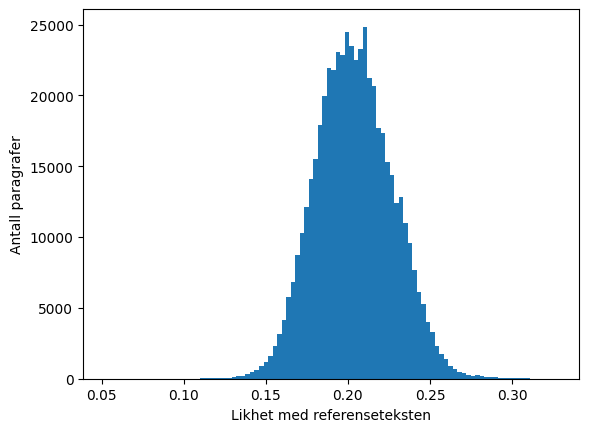

In [6]:
sims = np.concatenate(df["sims"].values)
plt.hist(sims, bins=100)
plt.xlabel("Likhet med referenseteksten")
plt.ylabel("Antall paragrafer")
plt.show()

Vi observerer at likhetene nesten alltid ligger mellom 0.15-0.25. Noter at lavere score nå betyr mer likhet. Modellen vi bruker er best på å rangere likhetene, og ikke på å gi absolutte verdier. Det vil si at selve verdien på en score ikke nødvendigvis sier så mye om likheten til referanseteksten. Det er derfor viktig å se på sammenhengen mellom scorene for å forstå likheten. 

For å gjøre scorene mer tolkbare skalerer vi derfor alle verdiene slik at de ligger mellom 0 og 1. I tillegg "flipper" vi verdiene så den likeste teksten får en score på 1, og den mest ulike får en score på 0. Det vil si at høyere score vil bety høyere likhet.

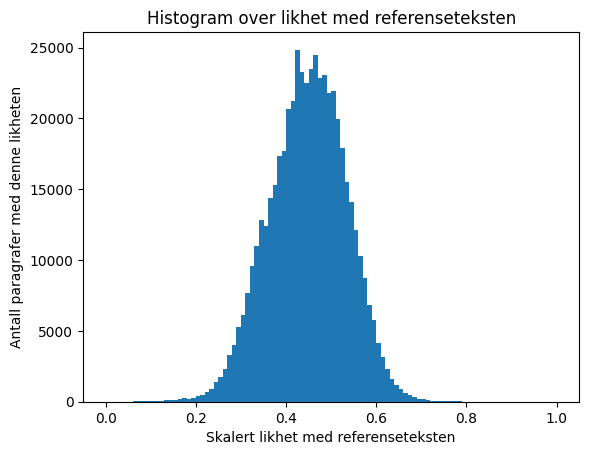

In [7]:
scaler = MinMaxScaler()
# combine all the arrays in df['sims'] into one array to fit the scaler
sims = np.concatenate(df["sims"].values).reshape(-1, 1)
scaler.fit(sims)
df["sims_scaled"] = df["sims"].apply(
    lambda x: 1 - scaler.transform(np.array(x).reshape(-1, 1)).flatten()
    if len(x) > 0
    else []
)
sims = np.concatenate(df["sims_scaled"].values)
plt.hist(sims, bins=100)
plt.title("Histogram over likhet med referenseteksten")
plt.xlabel("Skalert likhet med referenseteksten")
plt.ylabel("Antall paragrafer med denne likheten")
plt.show()

Nå har altså hver paragraf fått en score mellom 0 til 1 (0% til 100%) som sier noe om hvor lik den er referanseteksten.

#### Hvordan kan vi hente dokumentene med best score?

Vi kan først forsøke å kalkulere gjennomsnitt-scoren til et dokument ved å ta gjennomsnittet av alle paragrafene i dokumentet. Dette gir oss en score for hvert dokument. Vi kan så sortere dokumentene etter denne scoren, og hente ut de dokumentene med høyest score.

In [8]:
df['split_paragraphs']

0       [(2, Introduksjon til\nvirksomheten\nog hovedt...
1       [(2, INTRODUKSJON TIL VIRKSOMHETEN OG HOVEDTAL...
2       [(1, Kunnskap og råd for rene og\nrike hav- og...
3       [(1, Check Point Threat Extraction secured thi...
4       [(1, Årsrapport 2017\nFelles innsats for forsk...
                              ...                        
1807    [(1, Kunsthøgskolen i Oslo\nPb 6853, St. Olavs...
1808    [(1, Høgskolen i Molde vitenskapelig høgskole ...
1809    [(1, Direktoratet for forvaltning og økonomist...
1810    [(1, Integrerings- og mangfoldsdirektoratet\nP...
1811                                                   []
Name: split_paragraphs, Length: 1812, dtype: object

In [9]:
df['sims_scaled']

0       [0.5579580331402824, 0.46281002690332196, 0.51...
1       [0.41521128069571167, 0.4669590517250408, 0.47...
2       [0.3533800384089003, 0.37544377620558056, 0.40...
3       [0.11861637808589776, 0.39152891604403417, 0.4...
4       [0.5443838870582781, 0.5515079667683964, 0.467...
                              ...                        
1807    [0.3603493551690745, 0.47662524731423095, 0.43...
1808    [0.35605407858802895, 0.50824572540001, 0.4513...
1809    [0.47258938675622486, 0.528588770051761, 0.564...
1810    [0.34838972077806807, 0.5245594150022459, 0.41...
1811                                                   []
Name: sims_scaled, Length: 1812, dtype: object

In [10]:
df['length_of_split_paragraphs'] = df['split_paragraphs'].apply(lambda l: [len(x[1]) for x in l])

In [140]:
mean_sims_scaled = np.mean(df['sims_scaled'].apply(lambda x: np.mean(x) if len(x) > 0 else 0))  # Calculate the mean of 'sims_scaled'

alpha = 16
df['deviation_scaled_with_length'] = [[(s - mean_sims_scaled) * l**(1/alpha) for s, l in zip(x, y)] for x, y in zip(df['sims_scaled'], df['length_of_split_paragraphs'])]

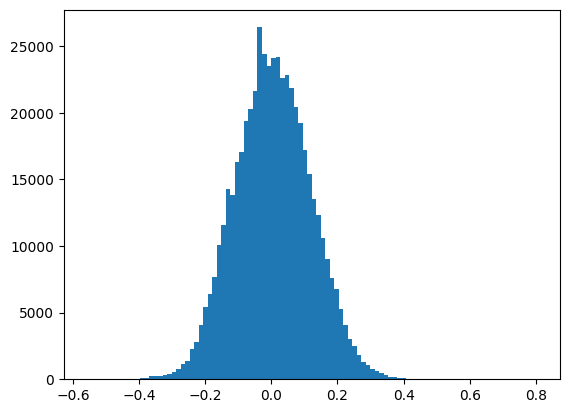

In [141]:
plt.hist(np.concatenate(df['deviation_scaled_with_length']), bins=100)
plt.show()

In [142]:
# Create a list to store tuples of (paragraph, score)
paragraphs_scores = []

# Iterate over the DataFrame
for _, row in df.iterrows():
    paras = row['split_paragraphs']
    sims = row['deviation_scaled_with_length']
    # Add all (paragraph, score) tuples to the list
    paragraphs_scores.extend(zip(paras, sims))

# Sort the list by score in descending order
paragraphs_scores.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 paragraphs and their scores
for i in range(5):
    print(paragraphs_scores[i][0][1])
    print(paragraphs_scores[i][1])
    print()

«Innovasjon i offentlig sektor er å
iverksette noe nytt som skaper verdi for
innbyggerne og for samfunnet. Det kan
være en ny eller vesentlig endret
tjeneste, produkt, prosess, organisering
eller kommunikasjonsmåte, og åpner for
å tenke nytt om hvordan Norge kan løse
store samfunnsoppgaver og utvikle
offentlig sektor. Slik kan innovasjon
bidra til langsiktig og bærekraftig
effektivitet» (Innovasjonsmeldingen).
0.8038495951672486

Offentlig sektor - et viktigere innovasjonsområde
Innovasjon i offentlig sektor er også en viktig del av samfunnets
omstillingsbehov. Forskning og innovasjon er nødvendig for
bærekraftige løsninger gjennom bruk av ny teknologi, nye
arbeids- og organisasjonsformer, og samspill mellom offentlig
0.6787201745897149

Offentlig sektor - et viktigere innovasjonsområde
Innovasjon i offentlig sektor er også en viktig del av samfunnets
omstillingsbehov. Forskning og innovasjon er nødvendig for
bærekraftige løsninger gjennom bruk av ny teknologi, nye
arbeids- og organisa

In [14]:
df['length_of_split_paragraphs']

0       [42, 31, 34, 29, 32, 49, 32, 29, 26, 894, 29, ...
1       [42, 46, 31, 81, 69, 45, 45, 85, 43, 130, 30, ...
2       [52, 30, 61, 30, 35, 36, 42, 82, 67, 26, 39, 3...
3       [51, 33, 27, 535, 38, 53, 28, 50, 113, 34, 28,...
4       [58, 488, 407, 28, 278, 1153, 26, 176, 39, 26,...
                              ...                        
1807    [55, 663, 50, 33, 41, 60, 38, 40, 62, 31, 44, ...
1808    [77, 682, 53, 48, 32, 39, 60, 38, 40, 62, 37, ...
1809    [72, 104, 166, 43, 61, 109, 40, 64, 738, 29, 1...
1810    [63, 1749, 61, 41, 40, 31, 40, 752, 1424, 70, ...
1811                                                   []
Name: length_of_split_paragraphs, Length: 1812, dtype: object

In [15]:
import numpy as np

def weighted_mean(row):
    if len(row['sims_scaled']) == 0:
        return 0
    return np.average(row['sims_scaled'], weights=row['length_of_split_paragraphs'])

df['weighted_mean_sims'] = df.apply(weighted_mean, axis=1)

In [16]:
df["pure_mean_sims"] = df["sims_scaled"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

In [17]:
df['lengths'] = df["sims_scaled"].apply(lambda x: len(x))

Dette gjør det veldig lett å hente ut de mest relevante dokumentene. Her henter vi ut dokumentet med høyest gjennomsnittlig score.

In [18]:
n = 8
max_idx = df["weighted_mean_sims"].values
second_highest = np.partition(max_idx, -n)[-n]
idx = np.where(max_idx == second_highest)[0][0]
df.loc[idx]

id                                                                          27284
uuid                                         152f8e86-2db6-4b91-b5b8-1464a09955d2
type                                                               Tildelingsbrev
title                                          Oppdragsbrev Innovasjon Norge 2022
subtitle                                                                      NaN
                                                      ...                        
length_of_split_paragraphs      [47, 67, 60, 27, 44, 46, 54, 50, 660, 61, 43, ...
deviation_scaled_with_length    [6.1649330209346385, 6.665668736404065, -5.172...
weighted_mean_sims                                                       0.595267
pure_mean_sims                                                           0.512329
lengths                                                                        47
Name: 1591, Length: 65, dtype: object

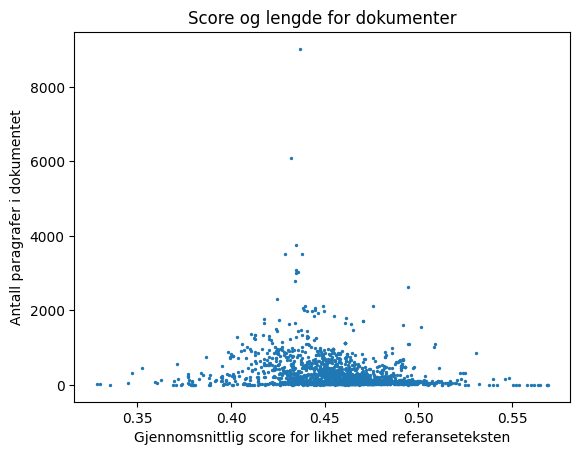

In [19]:
lengths = df["lengths"]
# vi vil fjerne dokumenter som ikke har noen paragrafer fra plottet
mask = lengths != 0
masked_df = df[mask]
plt.scatter(
    masked_df["pure_mean_sims"], masked_df["lengths"], s=2
)
plt.xlabel("Gjennomsnittlig score for likhet med referanseteksten")
plt.ylabel("Antall paragrafer i dokumentet")
plt.title('Score og lengde for dokumenter')
plt.show()

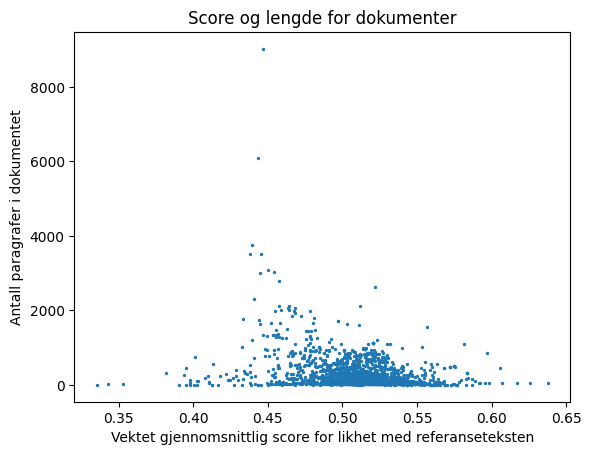

In [20]:
lengths = df["lengths"]
# vi vil fjerne dokumenter som ikke har noen paragrafer fra plottet
mask = lengths != 0
masked_df = df[mask]
plt.scatter(
    masked_df["weighted_mean_sims"], masked_df["lengths"], s=2
)
plt.xlabel("Vektet gjennomsnittlig score for likhet med referanseteksten")
plt.ylabel("Antall paragrafer i dokumentet")
plt.title('Score og lengde for dokumenter')
plt.show()

Det vi observerer her minner om en normalfordeling. Det er mer usikkerhet for hva den gjennomsnittlig scoren for paragrafene hvis antall paragrafer er lavt, så de gir utslag på begge sider av midten. Hvis vi da prøver å finne dokumentet med høyest score vil vi få resultat som er veldig påvirket av lengden til dokumentet, som vi ikke ønsker.

For å sikre at scoren vi gir et dokument signaliserer dens likhet med referanseteksten, kan vi ta gjennomsnittet av de k beste paragrafene i dokumentet. Dette vil gi oss en score som er mer påvirket av de beste paragrafene i dokumentet, og ikke så mye av de dårligste. Vi prøver med ulike verdier av k.

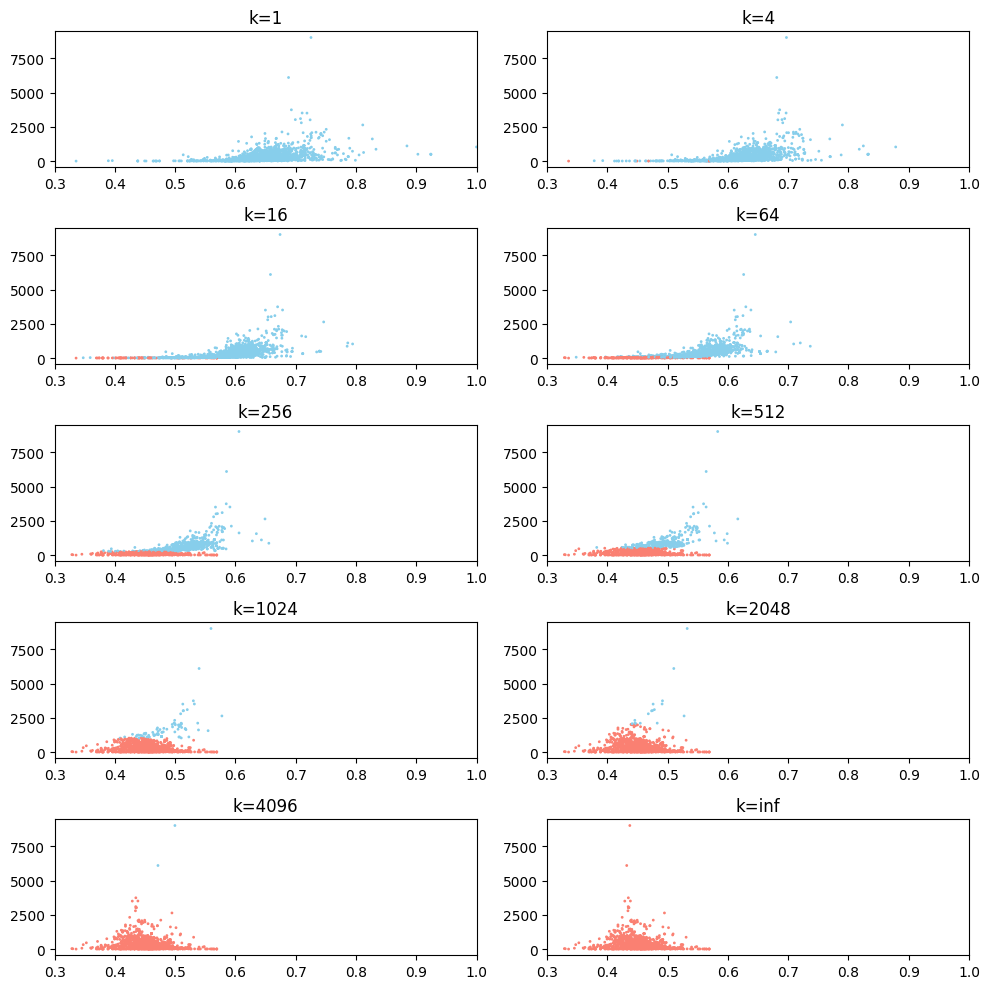

In [21]:
k_values = [1, 4, 16, 64, 256, 512, 1024, 2048, 4096, np.inf]

grid_size = (5, 2)
fig, axs = plt.subplots(*grid_size, figsize=(10, 10))

global_x_min = 0.3
global_x_max = 1

for i, k in enumerate(k_values):
    df["top_k"] = df["sims_scaled"].apply(
        lambda x: np.partition(x, -k)[-k:] if len(x) > k else x if len(x) > 0 else []
    )
    df["top_k_mean"] = df["top_k"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    lengths = df["lengths"]
    mask = lengths != 0
    masked_df = df[mask]
    
    ax = axs[i // grid_size[1], i % grid_size[1]]
    ax.set_xlim(global_x_min, global_x_max)
    ax.set_xticks(np.arange(global_x_min, global_x_max + 0.1, 0.1))

    colors = ['salmon' if len(x) < k else 'skyblue' for x in df["sims_scaled"]]
    ax.scatter(
        df["top_k_mean"], df["lengths"], s=1, c=colors
    )
    ax.set_title(f"k={k}")

# Display the plots
plt.tight_layout()
plt.show()

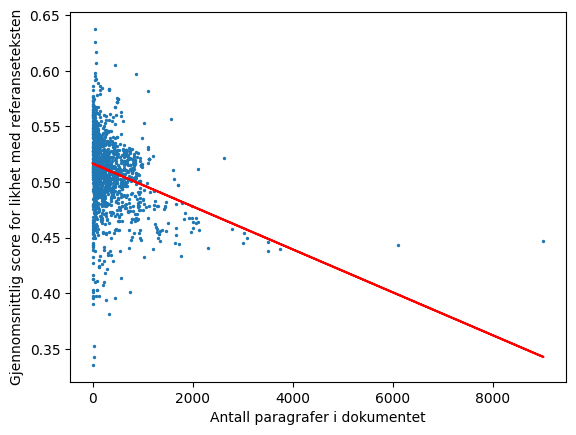

In [22]:
x = masked_df["lengths"].values.reshape(-1, 1)
y = masked_df["weighted_mean_sims"].values

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Predict y values for the regression line
y_pred = model.predict(x)

# Plot the data and the regression line
plt.scatter(x, y, s=2)
plt.plot(x, y_pred, color="red")
plt.ylabel("Gjennomsnittlig score for likhet med referanseteksten")
plt.xlabel("Antall paragrafer i dokumentet")
plt.show()

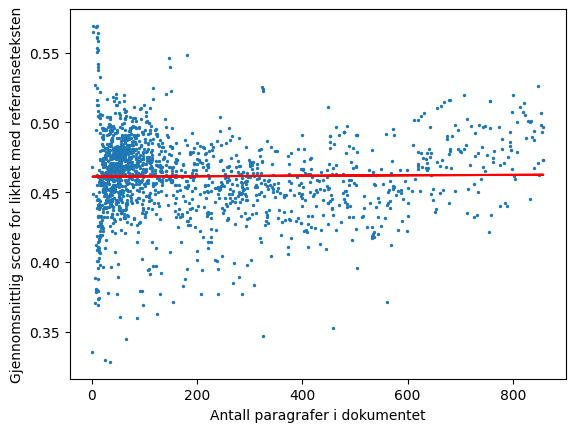

Best k: 563


In [23]:
def get_model(k, df=df, return_x_y: bool = False):
    df["top_k"] = df["sims_scaled"].apply(
        lambda x: np.partition(x, -k)[-k:] if len(x) > k else x if len(x) > 0 else []
    )
    df["top_k_mean"] = df["top_k"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    lengths = df["lengths"]
    Q1 = lengths.quantile(0.25)
    Q3 = lengths.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (lengths >= lower_bound) & (lengths <= upper_bound) & (lengths != 0)
    masked_df = df[mask]

    # Invert the graph by swapping x and y
    x = masked_df["lengths"].values.reshape(-1, 1)
    y = masked_df["top_k_mean"].values

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x, y)
    if return_x_y:
        return model, x, y
    return model

def get_slope(k):
    model = get_model(k)

    # Return the absolute slope
    return abs(model.coef_[0])


# Binary search
left, right = 1, df["lengths"].max() // 16  # Adjust the range as needed
while right - left > 1:
    mid = (left + right) // 2
    if get_slope(mid) < get_slope(mid + 1):
        right = mid
    else:
        left = mid

best_k = left if get_slope(left) < get_slope(right) else right

k = best_k
model, x, y = get_model(k, return_x_y=True)

# Predict y values for the regression line
y_pred = model.predict(x)

# Plot the data and the regression line
plt.scatter(x, y, s=2)
plt.plot(x, y_pred, color="red")
plt.ylabel("Gjennomsnittlig score for likhet med referanseteksten")
plt.xlabel("Antall paragrafer i dokumentet")
plt.show()
print(f"Best k: {k}")

Basert på en rekke faktorer tror jeg k=16 er hensiktsmessig

In [24]:
k = 16
get_model(k, df, return_x_y=False)
df.nlargest(10, "top_k_mean")[["title", 'name']]

,title,name
662,Årsrapport Digitaliseringsdirektoratet 2022,DIGITALISERINGSDIREKTORATET
239,Årsrapport Forskningsrådet 2019,NORGES FORSKNINGSRÅD
313,Årsrapport Digdir 2018,DIGITALISERINGSDIREKTORATET
405,Årsrapport Digitaliseringsdirektoratet 2019,DIGITALISERINGSDIREKTORATET
481,Årsrapport Bufdir 2021,"BARNE-, UNGDOMS- OG FAMILIEDIREKTORATET"
687,Årsrapport Universitetet i Sørøst-Norge 2022,UNIVERSITETET I SØRØST-NORGE
120,Årsrapport Digitaliseringsdirektoratet 2020,DIGITALISERINGSDIREKTORATET
358,Krav til årsrapport og årsregnskap,STATENS JERNBANETILSYN
1749,Oppdrag om å orientere om styrket satsingen på...,KLIMA- OG MILJØDEPARTEMENTET
580,Rapporteringskrav for årsrapport 2023,SIKT - KUNNSKAPSSEKTORENS TJENESTELEVERANDØR


In [25]:
print(masked_df['name'].value_counts().to_dict())

{'NÆRINGS- OG FISKERIDEPARTEMENTET': 139, 'JUSTIS- OG BEREDSKAPSDEPARTEMENTET': 108, 'KULTUR- OG LIKESTILLINGSDEPARTEMENTET': 82, 'HELSE- OG OMSORGSDEPARTEMENTET': 80, 'KUNNSKAPSDEPARTEMENTET': 76, 'ARBEIDS- OG INKLUDERINGSDEPARTEMENTET': 67, 'KLIMA- OG MILJØDEPARTEMENTET': 65, 'KOMMUNAL- OG DISTRIKTSDEPARTEMENTET': 62, 'LANDBRUKS- OG MATDEPARTEMENTET': 46, 'SAMFERDSELSDEPARTEMENTET': 42, 'DIGITALISERINGS- OG FORVALTNINGSDEPARTEMENTET (DFD)': 39, 'BARNE- OG FAMILIEDEPARTEMENTET': 33, 'FINANSDEPARTEMENTET': 32, 'ENERGIDEPARTEMENTET': 30, 'FORSVARSDEPARTEMENTET': 24, 'NORGES FORSKNINGSRÅD': 19, 'NASJONALBIBLIOTEKET': 14, 'JERNBANEDIREKTORATET': 13, 'DIREKTORATET FOR HØYERE UTDANNING OG KOMPETANSE': 12, 'HELSEDIREKTORATET': 11, 'MILJØDIREKTORATET': 10, 'NORGES VASSDRAGS- OG ENERGIDIREKTORAT (NVE)': 9, 'UTENRIKSDEPARTEMENTET': 9, 'STATISTISK SENTRALBYRÅ': 9, 'HUSBANKEN': 8, 'STATENS VEGVESEN': 8, 'NIBIO - NORSK INSTITUTT FOR BIOØKONOMI': 8, 'ARBEIDSTILSYNET': 8, 'STATENS HELSETILSYN': 8, '

Kanskje man ikke bør ta gjennomsnittet her?

/tmp/ipykernel_19875/4030327530.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choose a colormap as needed


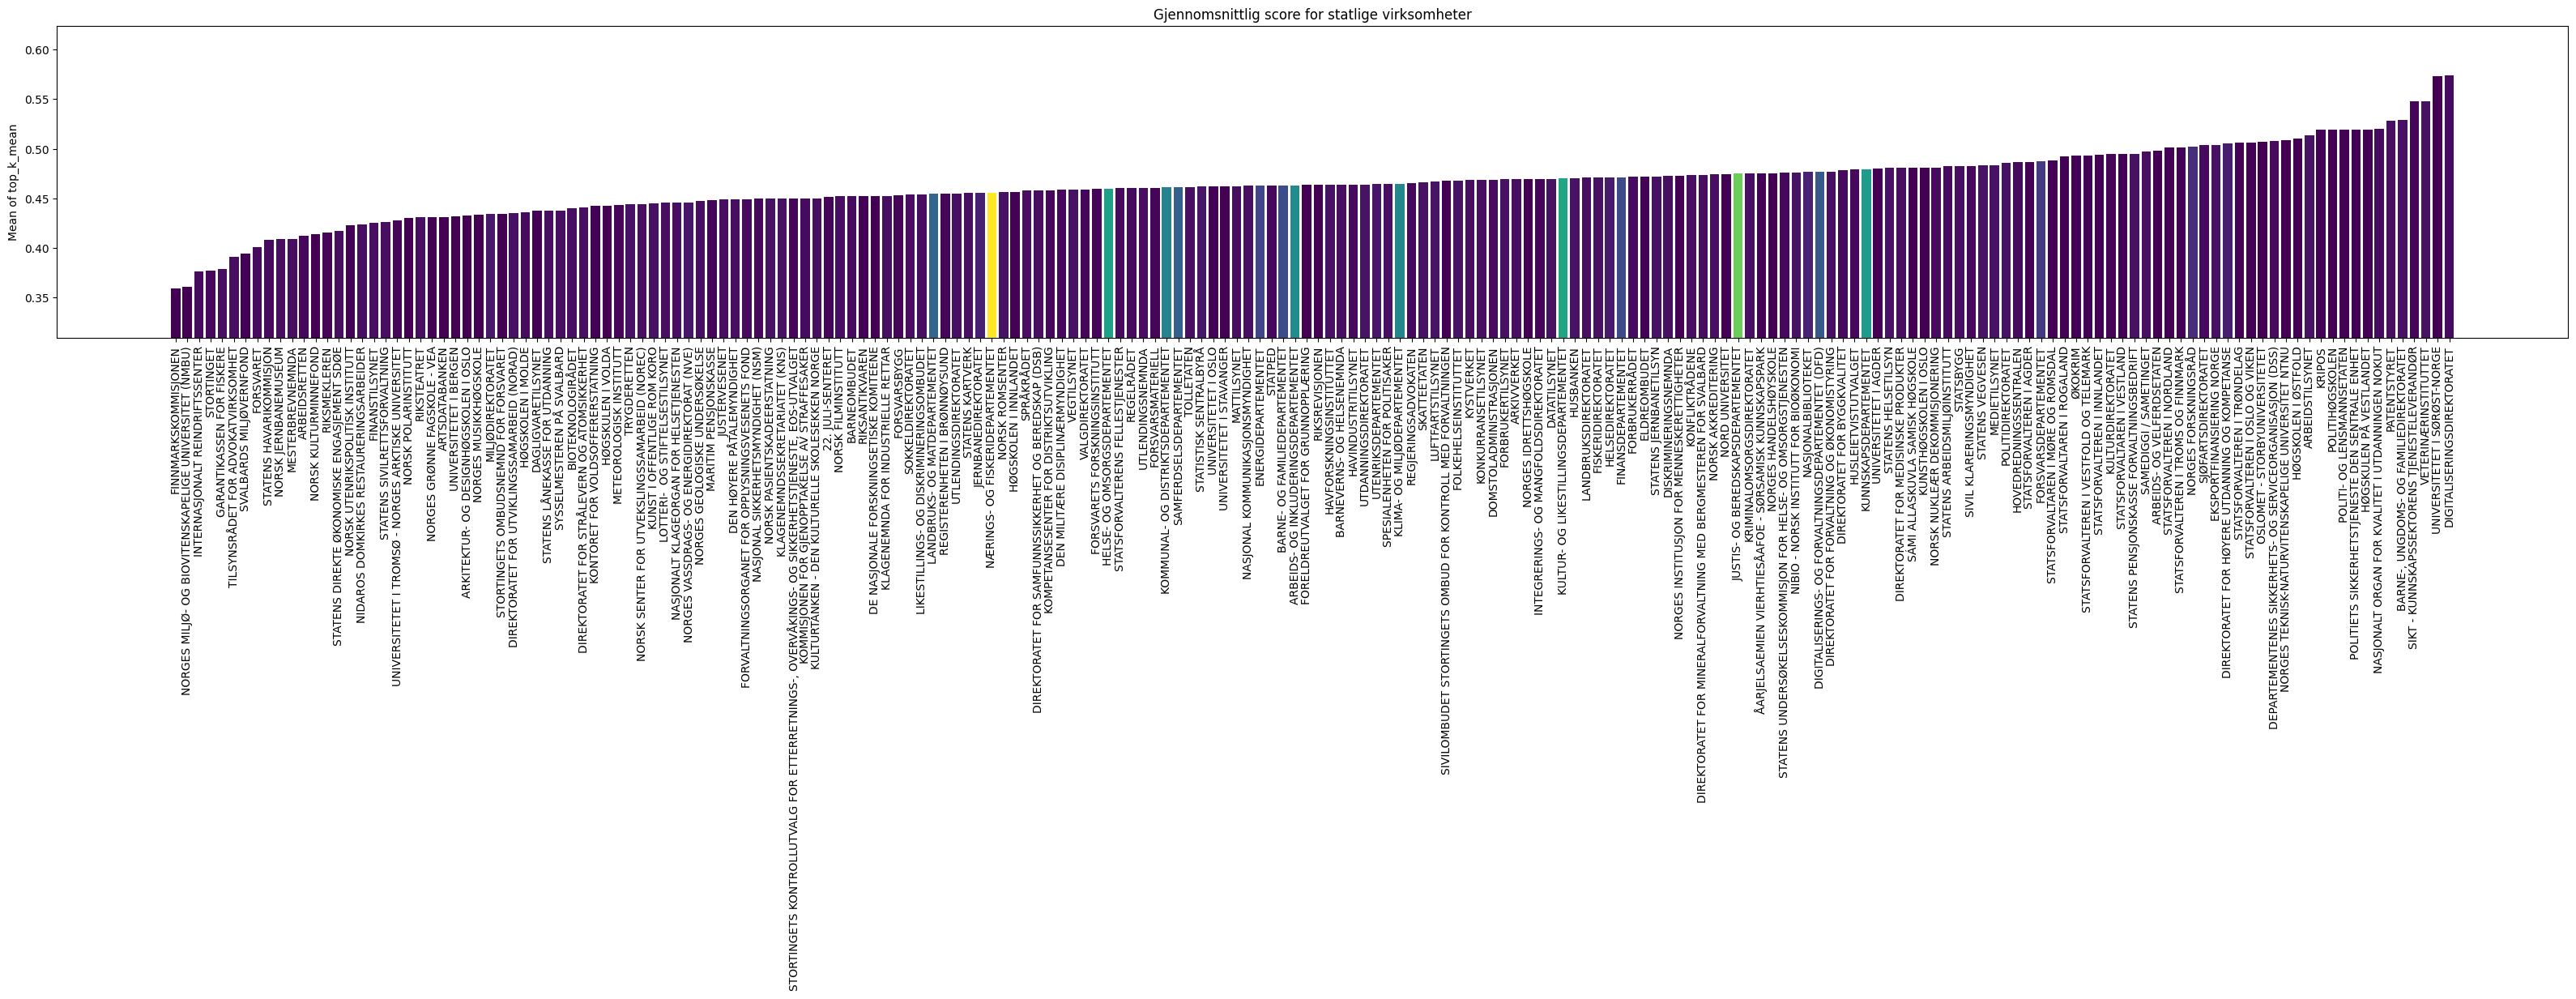

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

lengths = df["lengths"]
mask = lengths != 0
masked_df = df[mask]

# Group by 'name' and calculate the mean of 'top_k_mean'
mean_values = masked_df.groupby('name')['top_k_mean'].mean()

# Calculate the number of documents in each group
num_docs = masked_df['name'].value_counts()

# Sort the values
mean_values = mean_values.sort_values()

# Normalize 'num_docs' for color mapping
norm = plt.Normalize(num_docs.min(), num_docs.max())

# Create a colormap
cmap = cm.get_cmap('viridis')  # Choose a colormap as needed

# Map 'num_docs' to colors
colors = cmap(norm(num_docs.loc[mean_values.index].fillna(0)))

# Create a larger bar plot with colored bars
plt.figure(figsize=(40, 5))  # Increase the size as needed
plt.bar(mean_values.index, mean_values.values, color=colors)

# Add labels and title
plt.ylabel('Mean of top_k_mean')
plt.title('Gjennomsnittlig score for statlige virksomheter')

# Rotate x-axis labels
plt.xticks(rotation=90)  # Adjust the angle as needed

lim = 0.05
plt.ylim([mean_values.min() - lim, mean_values.max() + lim])

# Display the plot
plt.show()

In [27]:
df.head(1)

,id,uuid,type,title,subtitle,original_title,isbn,isbn_printed,issn,redirect_to_id,...,split_paragraphs,sims,sims_scaled,length_of_split_paragraphs,deviation_scaled_with_length,weighted_mean_sims,pure_mean_sims,lengths,top_k,top_k_mean
0,1,d111d3a2-a5a4-4cb9-a4e9-326a268c1fb3,Årsrapport,Årsrapport Statens Sivilrettsforvaltning 2020,NaN,NaN,NaN,NaN,NaN,NaN,...,"[(2, Introduksjon til\nvirksomheten\nog hovedt...","[0.1738506558834667, 0.19999809507920474, 0.18...","[0.5579580331402824, 0.46281002690332196, 0.51...","[42, 31, 34, 29, 32, 49, 32, 29, 26, 894, 29, ...","[4.604300119849993, 0.44882379987684196, 2.375...",0.493428,0.448499,400,"[0.5579580331402824, 0.46281002690332196, 0.51...",0.448499


/tmp/ipykernel_19875/876035782.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choose a colormap as needed


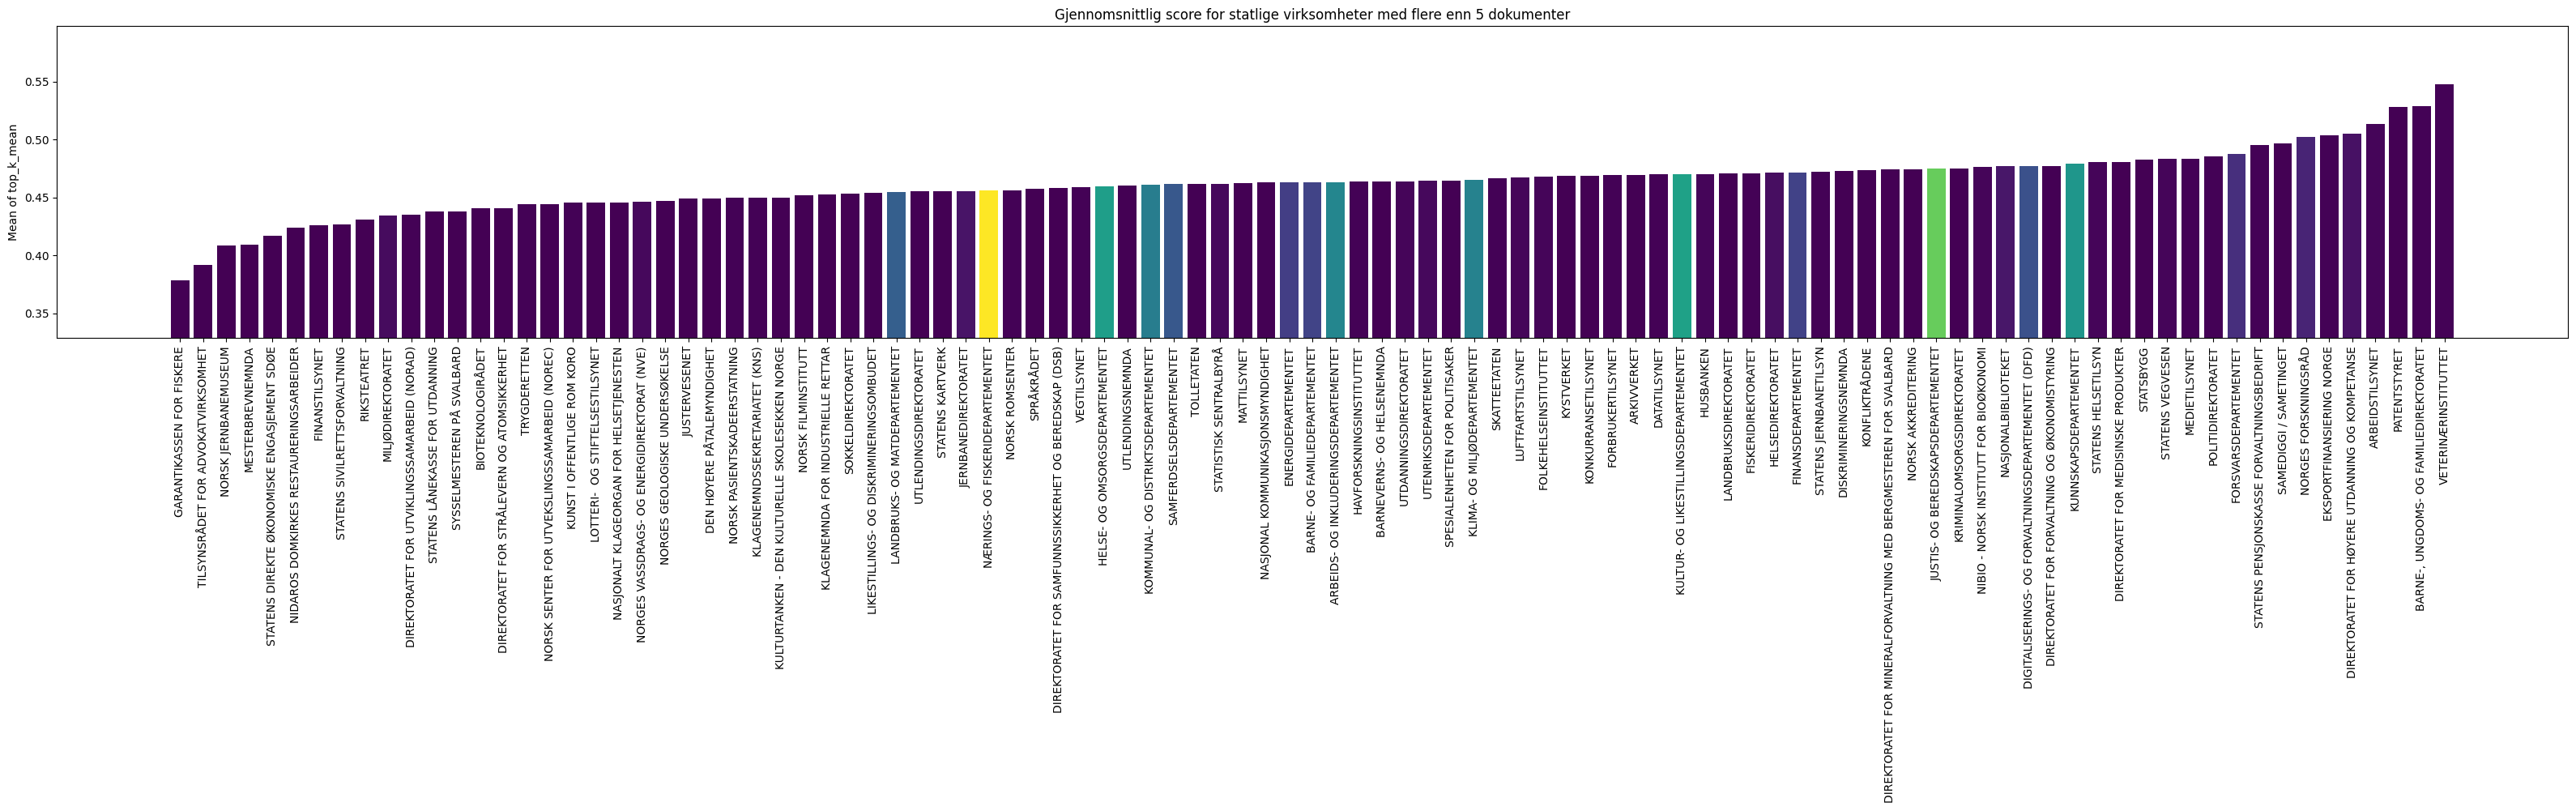

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

lengths = df["lengths"]
mask = lengths != 0
masked_df = df[mask]

# Group by 'name' and calculate the mean of 'top_k_mean'
mean_values = masked_df.groupby('name')['top_k_mean'].mean()

# Calculate the number of documents in each group
num_docs = masked_df['name'].value_counts()

# Filter 'num_docs' to only include names with more than 5 documents
num_docs = num_docs[num_docs > 5]

# Filter 'mean_values' to only include names in 'num_docs'
mean_values = mean_values[mean_values.index.isin(num_docs.index)]

# Sort the values
mean_values = mean_values.sort_values()

# Normalize 'num_docs' for color mapping
norm = plt.Normalize(num_docs.min(), num_docs.max())

# Create a colormap
cmap = cm.get_cmap('viridis')  # Choose a colormap as needed

# Map 'num_docs' to colors
colors = cmap(norm(num_docs.loc[mean_values.index].fillna(0)))

# Create a larger bar plot with colored bars
plt.figure(figsize=(40, 5))  # Increase the size as needed
plt.bar(mean_values.index, mean_values.values, color=colors)

# Add labels and title
plt.ylabel('Mean of top_k_mean')
plt.title('Gjennomsnittlig score for statlige virksomheter med flere enn 5 dokumenter')

# Rotate x-axis labels
plt.xticks(rotation=90)  # Adjust the angle as needed

lim = 0.05
plt.ylim([mean_values.min() - lim, mean_values.max() + lim])

# Display the plot
plt.show()

Her er alle mulige virksomheter

In [29]:
[print(x) for x in mean_values.index.to_list()]
pass

GARANTIKASSEN FOR FISKERE
TILSYNSRÅDET FOR ADVOKATVIRKSOMHET
NORSK JERNBANEMUSEUM
MESTERBREVNEMNDA
STATENS DIREKTE ØKONOMISKE ENGASJEMENT SDØE
NIDAROS DOMKIRKES RESTAURERINGSARBEIDER
FINANSTILSYNET
STATENS SIVILRETTSFORVALTNING
RIKSTEATRET
MILJØDIREKTORATET
DIREKTORATET FOR UTVIKLINGSSAMARBEID (NORAD)
STATENS LÅNEKASSE FOR UTDANNING
SYSSELMESTEREN PÅ SVALBARD
BIOTEKNOLOGIRÅDET
DIREKTORATET FOR STRÅLEVERN OG ATOMSIKKERHET
TRYGDERETTEN
NORSK SENTER FOR UTVEKSLINGSSAMARBEID (NOREC)
KUNST I OFFENTLIGE ROM KORO
LOTTERI-  OG STIFTELSESTILSYNET
NASJONALT KLAGEORGAN FOR HELSETJENESTEN
NORGES VASSDRAGS- OG ENERGIDIREKTORAT (NVE)
NORGES GEOLOGISKE UNDERSØKELSE
JUSTERVESENET
DEN HØYERE PÅTALEMYNDIGHET
NORSK PASIENTSKADEERSTATNING
KLAGENEMNDSSEKRETARIATET (KNS)
KULTURTANKEN - DEN KULTURELLE SKOLESEKKEN NORGE
NORSK FILMINSTITUTT
KLAGENEMNDA FOR INDUSTRIELLE RETTAR
SOKKELDIREKTORATET
LIKESTILLINGS- OG DISKRIMINERINGSOMBUDET
LANDBRUKS- OG MATDEPARTEMENTET
UTLENDINGSDIREKTORATET
STATENS KARTVERK
JERNB